# Blind case study: academic citation feature

# Setup

In [ ]:
from transcoder_circuits.circuit_analysis import *
from transcoder_circuits.feature_dashboards import *
from transcoder_circuits.replacement_ctx import *

## Load model

In [2]:
from sae_training.sparse_autoencoder import SparseAutoencoder

In [ ]:
from transformer_lens import HookedTransformer, utils
model = HookedTransformer.from_pretrained('gpt2')

## Loading data

In [4]:
# This function was stolen from one of Neel Nanda's exploratory notebooks
# Thanks, Neel!
import einops
def tokenize_and_concatenate(
    dataset,
    tokenizer,
    streaming = False,
    max_length = 1024,
    column_name = "text",
    add_bos_token = True,
):
    """Helper function to tokenizer and concatenate a dataset of text. This converts the text to tokens, concatenates them (separated by EOS tokens) and then reshapes them into a 2D array of shape (____, sequence_length), dropping the last batch. Tokenizers are much faster if parallelised, so we chop the string into 20, feed it into the tokenizer, in parallel with padding, then remove padding at the end.

    This tokenization is useful for training language models, as it allows us to efficiently train on a large corpus of text of varying lengths (without, eg, a lot of truncation or padding). Further, for models with absolute positional encodings, this avoids privileging early tokens (eg, news articles often begin with CNN, and models may learn to use early positional encodings to predict these)

    Args:
        dataset (Dataset): The dataset to tokenize, assumed to be a HuggingFace text dataset.
        tokenizer (AutoTokenizer): The tokenizer. Assumed to have a bos_token_id and an eos_token_id.
        streaming (bool, optional): Whether the dataset is being streamed. If True, avoids using parallelism. Defaults to False.
        max_length (int, optional): The length of the context window of the sequence. Defaults to 1024.
        column_name (str, optional): The name of the text column in the dataset. Defaults to 'text'.
        add_bos_token (bool, optional): . Defaults to True.

    Returns:
        Dataset: Returns the tokenized dataset, as a dataset of tensors, with a single column called "tokens"

    Note: There is a bug when inputting very small datasets (eg, <1 batch per process) where it just outputs nothing. I'm not super sure why
    """
    for key in dataset.features:
        if key != column_name:
            dataset = dataset.remove_columns(key)

    if tokenizer.pad_token is None:
        # We add a padding token, purely to implement the tokenizer. This will be removed before inputting tokens to the model, so we do not need to increment d_vocab in the model.
        tokenizer.add_special_tokens({"pad_token": "<PAD>"})
    # Define the length to chop things up into - leaving space for a bos_token if required
    if add_bos_token:
        seq_len = max_length - 1
    else:
        seq_len = max_length

    def tokenize_function(examples):
        text = examples[column_name]
        # Concatenate it all into an enormous string, separated by eos_tokens
        full_text = tokenizer.eos_token.join(text)
        # Divide into 20 chunks of ~ equal length
        num_chunks = 20
        chunk_length = (len(full_text) - 1) // num_chunks + 1
        chunks = [
            full_text[i * chunk_length : (i + 1) * chunk_length]
            for i in range(num_chunks)
        ]
        # Tokenize the chunks in parallel. Uses NumPy because HuggingFace map doesn't want tensors returned
        tokens = tokenizer(chunks, return_tensors="np", padding=True)[
            "input_ids"
        ].flatten()
        # Drop padding tokens
        tokens = tokens[tokens != tokenizer.pad_token_id]
        num_tokens = len(tokens)
        num_batches = num_tokens // (seq_len)
        # Drop the final tokens if not enough to make a full sequence
        tokens = tokens[: seq_len * num_batches]
        tokens = einops.rearrange(
            tokens, "(batch seq) -> batch seq", batch=num_batches, seq=seq_len
        )
        if add_bos_token:
            prefix = np.full((num_batches, 1), tokenizer.bos_token_id)
            tokens = np.concatenate([prefix, tokens], axis=1)
        return {"tokens": tokens}

    tokenized_dataset = dataset.map(
        tokenize_function,
        batched=True,
        remove_columns=[column_name],
    )
    #tokenized_dataset.set_format(type="torch", columns=["tokens"])
    return tokenized_dataset


In [5]:
from datasets import load_dataset
from huggingface_hub import HfApi

dataset = load_dataset('Skylion007/openwebtext', split='train', streaming=True)
dataset = dataset.shuffle(seed=42, buffer_size=10_000)
tokenized_owt = tokenize_and_concatenate(dataset, model.tokenizer, max_length=128, streaming=True)
tokenized_owt = tokenized_owt.shuffle(42)
tokenized_owt = tokenized_owt.take(12800*2)
owt_tokens = np.stack([x['tokens'] for x in tokenized_owt])

Token indices sequence length is longer than the specified maximum sequence length for this model (73252 > 1024). Running this sequence through the model will result in indexing errors


In [6]:
owt_tokens_torch = torch.from_numpy(owt_tokens).cuda()

# Load transcoders

In [7]:
transcoder_template = "./gpt-2-small-transcoders/final_sparse_autoencoder_gpt2-small_blocks.{}.ln2.hook_normalized_24576"
transcoders = []
sparsities = []
for i in range(12):
    transcoders.append(SparseAutoencoder.load_from_pretrained(f"{transcoder_template.format(i)}.pt").eval())
    sparsities.append(torch.load(f"{transcoder_template.format(i)}_log_feature_sparsity.pt"))

In [8]:
import gc
gc.collect()
torch.cuda.empty_cache()

## Load transcoder 8 feature frequency info

In [11]:
live_features = np.arange(len(sparsities[8]))[utils.to_numpy(sparsities[8] > -4)]

# Blind case study: `live_features[300]`

In a blind feature case study, we try to begin by reverse-engineering a transcoder feature *without looking at the top-activating examples*. We then form a hypothesis about what the transcoder feature is computing, and only after having done so do we look at the top-activating examples to see if our hypothesis is supported.

In [41]:
feature_idx = live_features[300]
my_feature = make_sae_feature_vector(transcoders[8], feature_idx, use_encoder=True, token=-1)
print(my_feature)

mlp8tc[355]@-1


In [155]:
# get scores
scores = get_feature_scores(model, transcoders[8], owt_tokens_torch[:128*100], feature_idx, batch_size=128, use_raw_scores=False)
uniform_samples = sample_uniform(scores, num_samples=50)

  0%|          | 0/100 [00:00<?, ?it/s]

Let's get the indices of sufficiently-highly activating examples.

In [156]:
uniform_scores, uniform_idxs = uniform_samples[0], uniform_samples[1]
print(uniform_scores)

[ 0.      0.2988  0.5957  0.895   1.192   1.491   1.79    2.088   2.383
  2.69    2.986   3.242   3.58    3.877   4.18    4.47    4.754   5.055
  5.35    5.66    6.06    6.28    6.41    6.848   7.16    7.477   7.59
  8.04    8.266   8.914   9.305   9.586   9.97   10.055  10.5    10.81
 11.19   11.35   11.72   11.91   12.12   12.51   12.79   13.12   13.41
 13.6    14.61  ]


In [158]:
threshold = 11
uniform_idxs = uniform_idxs[uniform_scores>threshold]
uniform_scores = uniform_scores[uniform_scores>threshold]
for x in uniform_idxs: print(f'{x[0]}, {x[1]}')

5688, 114
10828, 72
6123, 65
5701, 37
5701, 121
2676, 31
2555, 108
6063, 47
6189, 79
6516, 37
3062, 90


## Input 5701, 37

In [42]:
prompt = owt_tokens_torch[5701, :37+1]
_, cache = model.run_with_cache(prompt)

In [43]:
all_paths = greedy_get_top_paths(model, transcoders, cache, my_feature, num_iters=5, num_branches=15)
print_all_paths(all_paths)

--- Paths of size 2 ---
Path [0][0]: mlp8tc[355]@-1 <- mlp6tc[11831]@37: 4.8
Path [0][1]: mlp8tc[355]@-1 <- attn7[7]@35: 3.6
Path [0][2]: mlp8tc[355]@-1 <- mlp5tc[12450]@37: 2.9
Path [0][3]: mlp8tc[355]@-1 <- mlp0tc[16632]@37: 2.9
Path [0][4]: mlp8tc[355]@-1 <- mlp0tc[9188]@37: 2.5
Path [0][5]: mlp8tc[355]@-1 <- mlp1tc[22184]@37: 2.4
Path [0][6]: mlp8tc[355]@-1 <- mlp2tc[3900]@37: 2.3
Path [0][7]: mlp8tc[355]@-1 <- attn5[6]@36: 2.1
Path [0][8]: mlp8tc[355]@-1 <- mlp7tc[10909]@37: 2.1
Path [0][9]: mlp8tc[355]@-1 <- mlp7tc[3100]@37: 1.5
Path [0][10]: mlp8tc[355]@-1 <- attn3[1]@31: 1.2
Path [0][11]: mlp8tc[355]@-1 <- mlp5tc[24026]@37: 1.2
Path [0][12]: mlp8tc[355]@-1 <- mlp0tc[9853]@37: 1.2
Path [0][13]: mlp8tc[355]@-1 <- attn4[11]@36: 1.2
Path [0][14]: mlp8tc[355]@-1 <- mlp3tc[6238]@37: 1.1
--- Paths of size 3 ---
Path [1][0]: mlp8tc[355]@-1 <- mlp0tc[9188]@37: 2.5 <- embed0@37: 2.5
Path [1][1]: mlp8tc[355]@-1 <- mlp0tc[16632]@37: 2.9 <- embed0@37: 2.3
Path [1][2]: mlp8tc[355]@-1 <- mlp0

We see contributions from various tokens: not only the final one, but also `attn7[7]@35`, `attn5[6]@36`, and others.

In [45]:
raw_paths = greedy_get_top_paths(model, transcoders, cache, my_feature, num_iters=5, num_branches=15, do_raw_attribution=True)
plot_paths(raw_paths)

First, though, let's focus on the final token.

### Final token

In [161]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 9188, k=5)

In [162]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 16632, k=5)

Okay, final token is a semicolon.

What's going on with `mlp6tc[11831]@-1`?

In [163]:
subcircuit = greedy_get_top_paths(model, transcoders, cache, all_paths[0][0][-1], num_iters=5, num_branches=15)
print_all_paths(subcircuit)

--- Paths of size 2 ---
Path [0][0]: mlp6tc[11831]@-1: 4.8 <- mlp5tc[12450]@-1: 0.46
Path [0][1]: mlp6tc[11831]@-1: 4.8 <- mlp0tc[16632]@-1: 0.45
Path [0][2]: mlp6tc[11831]@-1: 4.8 <- attn4[4]@36: 0.39
Path [0][3]: mlp6tc[11831]@-1: 4.8 <- mlp0tc[9188]@-1: 0.34
Path [0][4]: mlp6tc[11831]@-1: 4.8 <- mlp1tc[22184]@-1: 0.31
Path [0][5]: mlp6tc[11831]@-1: 4.8 <- mlp2tc[3900]@-1: 0.28
Path [0][6]: mlp6tc[11831]@-1: 4.8 <- mlp5tc[24026]@-1: 0.21
Path [0][7]: mlp6tc[11831]@-1: 4.8 <- attn3[1]@31: 0.21
Path [0][8]: mlp6tc[11831]@-1: 4.8 <- attn5[6]@36: 0.18
Path [0][9]: mlp6tc[11831]@-1: 4.8 <- mlp0tc[9853]@-1: 0.16
Path [0][10]: mlp6tc[11831]@-1: 4.8 <- mlp3tc[18385]@-1: 0.14
Path [0][11]: mlp6tc[11831]@-1: 4.8 <- attn0[1]@37: 0.13
Path [0][12]: mlp6tc[11831]@-1: 4.8 <- attn2[9]@36: 0.12
Path [0][13]: mlp6tc[11831]@-1: 4.8 <- mlp5tc[10550]@-1: 0.12
Path [0][14]: mlp6tc[11831]@-1: 4.8 <- attn4[8]@37: 0.11
--- Paths of size 3 ---
Path [1][0]: mlp6tc[11831]@-1: 4.8 <- mlp0tc[16632]@-1: 0.45 <- e

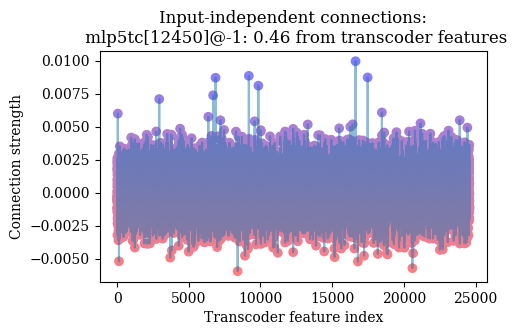

In [164]:
display_transcoder_pullback_features(model, subcircuit[0][0][-1], transcoders[0])

Yep, looks like all roads lead to semicolon.

### `attn7[7]@35`

In [165]:
subcircuit = greedy_get_top_paths(model, transcoders, cache, all_paths[0][1][-1], num_iters=5, num_branches=15)
print_all_paths(subcircuit)

--- Paths of size 2 ---
Path [0][0]: attn7[7]@35: 3.6 <- attn4[11]@34: 0.44
Path [0][1]: attn7[7]@35: 3.6 <- attn6[8]@34: 0.29
Path [0][2]: attn7[7]@35: 3.6 <- mlp6tc[17701]@35: 0.24
Path [0][3]: attn7[7]@35: 3.6 <- attn3[6]@32: 0.21
Path [0][4]: attn7[7]@35: 3.6 <- mlp6tc[21046]@35: 0.21
Path [0][5]: attn7[7]@35: 3.6 <- attn5[10]@17: 0.19
Path [0][6]: attn7[7]@35: 3.6 <- attn0[1]@35: 0.16
Path [0][7]: attn7[7]@35: 3.6 <- mlp4tc[23789]@35: 0.16
Path [0][8]: attn7[7]@35: 3.6 <- mlp4tc[12272]@35: 0.15
Path [0][9]: attn7[7]@35: 3.6 <- attn3[7]@34: 0.13
Path [0][10]: attn7[7]@35: 3.6 <- attn4[1]@31: 0.13
Path [0][11]: attn7[7]@35: 3.6 <- attn3[1]@31: 0.12
Path [0][12]: attn7[7]@35: 3.6 <- attn4[3]@33: 0.1
Path [0][13]: attn7[7]@35: 3.6 <- attn5[0]@35: 0.1
Path [0][14]: attn7[7]@35: 3.6 <- mlp4tc[11462]@35: 0.1
--- Paths of size 3 ---
Path [1][0]: attn7[7]@35: 3.6 <- attn3[6]@32: 0.21 <- mlp0tc[12584]@32: 0.082
Path [1][1]: attn7[7]@35: 3.6 <- attn6[8]@34: 0.29 <- mlp0tc[7659]@34: 0.08
Path

In [167]:
display_deembeddings_for_feature_vector(model, subcircuit[1][0][-1], k=5)

In [168]:
display_deembeddings_for_feature_vector(model, subcircuit[1][1][-1], k=5)

In [176]:
subcircuit2 = greedy_get_top_paths(model, transcoders, cache, subcircuit[0][2][-1], num_iters=5, num_branches=15)
subcircuit2 = get_paths_via_filter(subcircuit2, suffix_path=[FeatureFilter(layer=0, sublayer='resid_pre')])
print_all_paths(subcircuit2)

Path [0]: mlp6tc[17701]@35: 0.24 <- attn0[8]@31: 0.0089
Path [1]: mlp6tc[17701]@35: 0.24 <- attn6[8]@34: 0.036 <- attn0[1]@34: 0.0033
Path [2]: mlp6tc[17701]@35: 0.24 <- mlp5tc[13712]@35: 0.013 <- mlp0tc[16267]@35: 0.0035 <- embed0@35: 0.0035
Path [3]: mlp6tc[17701]@35: 0.24 <- attn6[8]@34: 0.036 <- mlp0tc[7659]@34: 0.0079 <- attn0[1]@34: 0.0033
Path [4]: mlp6tc[17701]@35: 0.24 <- attn5[10]@17: 0.034 <- mlp0tc[18839]@17: 0.0059 <- embed0@17: 0.003
Path [5]: mlp6tc[17701]@35: 0.24 <- attn5[10]@17: 0.034 <- mlp0tc[18839]@17: 0.0059 <- attn0[5]@17: 0.003
Path [6]: mlp6tc[17701]@35: 0.24 <- mlp5tc[13712]@35: 0.013 <- mlp0tc[16267]@35: 0.0035 <- attn0[1]@35: 0.003
Path [7]: mlp6tc[17701]@35: 0.24 <- attn3[6]@32: 0.015 <- mlp0tc[12584]@32: 0.0048 <- embed0@32: 0.0028
Path [8]: mlp6tc[17701]@35: 0.24 <- attn6[8]@34: 0.036 <- mlp0tc[7659]@34: 0.0079 <- embed0@34: 0.0028
Path [9]: mlp6tc[17701]@35: 0.24 <- attn3[6]@32: 0.015 <- mlp0tc[12584]@32: 0.0048 <- attn0[1]@32: 0.0022
Path [10]: mlp6tc[1

In [182]:
display_deembeddings_for_feature_vector(model, subcircuit2[1][-1], k=10)

### Filtered paths

In [47]:
filtered_paths = greedy_get_top_paths(model, transcoders, cache, my_feature, num_iters=5, num_branches=15,
                                 filter=FeatureFilter(token=37, token_filter_type=FilterType.NE))
print_all_paths(filtered_paths)

--- Paths of size 2 ---
Path [0][0]: mlp8tc[355]@-1 <- attn7[7]@35: 3.6
Path [0][1]: mlp8tc[355]@-1 <- attn5[6]@36: 2.1
Path [0][2]: mlp8tc[355]@-1 <- attn3[1]@31: 1.2
Path [0][3]: mlp8tc[355]@-1 <- attn4[11]@36: 1.2
Path [0][4]: mlp8tc[355]@-1 <- attn8[6]@35: 1.1
Path [0][5]: mlp8tc[355]@-1 <- attn3[6]@36: 1.0
Path [0][6]: mlp8tc[355]@-1 <- attn2[9]@36: 0.92
Path [0][7]: mlp8tc[355]@-1 <- attn2[2]@36: 0.67
Path [0][8]: mlp8tc[355]@-1 <- attn6[8]@36: 0.63
Path [0][9]: mlp8tc[355]@-1 <- attn7[7]@36: 0.57
Path [0][10]: mlp8tc[355]@-1 <- attn7[5]@17: 0.55
Path [0][11]: mlp8tc[355]@-1 <- attn6[3]@36: 0.49
Path [0][12]: mlp8tc[355]@-1 <- attn3[2]@35: 0.46
Path [0][13]: mlp8tc[355]@-1 <- attn6[10]@36: 0.44
Path [0][14]: mlp8tc[355]@-1 <- attn3[5]@36: 0.43
--- Paths of size 3 ---
Path [1][0]: mlp8tc[355]@-1 <- attn7[7]@35: 3.6 <- attn4[11]@34: 0.44
Path [1][1]: mlp8tc[355]@-1 <- attn5[6]@36: 2.1 <- mlp0tc[13196]@36: 0.31
Path [1][2]: mlp8tc[355]@-1 <- attn7[7]@35: 3.6 <- attn6[8]@34: 0.29
Pat

De-embeddings:
* `mlp0tc[13196]@36`: 1973 (then, to a lesser extent, 1971, 1967, 1966...)
* `mlp0tc[10109]@31`: ` (`
* `mlp8tc[355]attn7[7]attn0[1]@35`: "je", then " Haley", then " Jama", then "jay", then "kay"
* `mlp0tc[12584]@32`: `P`
* `mlp0tc[7659]@34`: `ck`

What's going on with `mlp6tc[21046]@35`? Let's take an input-independent look.

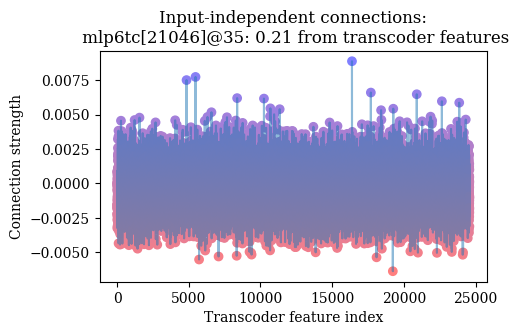

In [48]:
display_transcoder_pullback_features(model, filtered_paths[1][7][-1], transcoders[0])

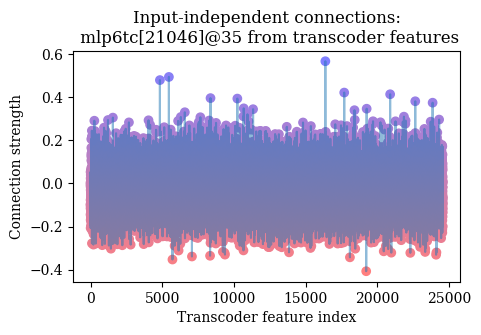

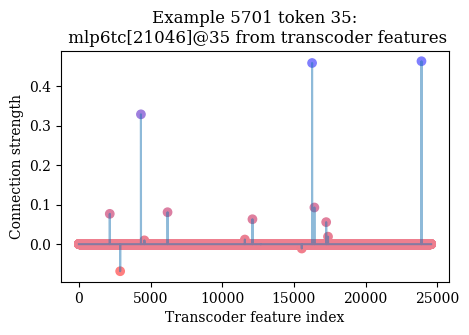

In [59]:
mlp6tc21046 = make_sae_feature_vector(transcoders[6], 21046, token=35)
display_transcoder_pullback_features(model, mlp6tc21046, transcoders[0])
display_transcoder_pullback_features(model, mlp6tc21046, transcoders[0], input_tokens=owt_tokens_torch, input_token_idx=35, input_example=5701)

In [50]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 5468, k=10)

In [194]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 16382, k=10)

Polish surnames. Neat.

### Current hypothesis

This feature so far has proven to be a bit of a doozy, but I think I've got a good hypothesis now.

Hint: token 31 is an open parenthesis ` (`. Token 36 is a year. Tokens 32-35 are some hard-to-tokenize surname (probably Polish in this case). The final token (token 37) is a semicolon `;`. Put this all together: what are we looking at?

**Current hypothesis**: Feature fires on parenthetical scientific citations that reference multiple works.

E.g. the semicolon in `(Piotrowski 1973; Kubota 1982)`

## Input 6063, 47

In [195]:
prompt = owt_tokens_torch[6063, :47+1]
_, cache = model.run_with_cache(prompt)

In [196]:
all_paths = greedy_get_top_paths(model, transcoders, cache, my_feature, num_iters=5, num_branches=15)
print_all_paths(all_paths)

--- Paths of size 2 ---
Path [0][0]: mlp8tc[355]@-1 <- mlp6tc[11831]@-1: 5.1
Path [0][1]: mlp8tc[355]@-1 <- mlp0tc[9188]@-1: 3.4
Path [0][2]: mlp8tc[355]@-1 <- mlp5tc[12450]@-1: 3.1
Path [0][3]: mlp8tc[355]@-1 <- mlp7tc[10909]@-1: 2.8
Path [0][4]: mlp8tc[355]@-1 <- mlp1tc[22184]@-1: 2.6
Path [0][5]: mlp8tc[355]@-1 <- mlp0tc[16632]@-1: 2.5
Path [0][6]: mlp8tc[355]@-1 <- mlp2tc[3900]@-1: 1.9
Path [0][7]: mlp8tc[355]@-1 <- attn6[8]@46: 1.6
Path [0][8]: mlp8tc[355]@-1 <- attn4[11]@46: 1.3
Path [0][9]: mlp8tc[355]@-1 <- attn3[1]@39: 1.3
Path [0][10]: mlp8tc[355]@-1 <- mlp3tc[6238]@-1: 1.2
Path [0][11]: mlp8tc[355]@-1 <- mlp7tc[3100]@-1: 1.2
Path [0][12]: mlp8tc[355]@-1 <- mlp5tc[24026]@-1: 1.2
Path [0][13]: mlp8tc[355]@-1 <- attn5[6]@46: 1.2
Path [0][14]: mlp8tc[355]@-1 <- mlp3tc[18385]@-1: 1.0
--- Paths of size 3 ---
Path [1][0]: mlp8tc[355]@-1 <- mlp0tc[9188]@-1: 3.4 <- embed0@-1: 2.7
Path [1][1]: mlp8tc[355]@-1 <- mlp0tc[16632]@-1: 2.5 <- embed0@-1: 2.2
Path [1][2]: mlp8tc[355]@-1 <- mlp

In [197]:
display_deembeddings_for_feature_vector(model, all_paths[0][1][-1])

Another semicolon. Let's filter out the last token again.

In [198]:
filtered_paths = greedy_get_top_paths(model, transcoders, cache, my_feature, num_iters=5, num_branches=15,
                                     filter=FeatureFilter(token=-1, token_filter_type=FilterType.NE))
print_all_paths(filtered_paths)

--- Paths of size 2 ---
Path [0][0]: mlp8tc[355]@-1 <- attn6[8]@46: 1.6
Path [0][1]: mlp8tc[355]@-1 <- attn4[11]@46: 1.3
Path [0][2]: mlp8tc[355]@-1 <- attn3[1]@39: 1.3
Path [0][3]: mlp8tc[355]@-1 <- attn5[6]@46: 1.2
Path [0][4]: mlp8tc[355]@-1 <- attn8[6]@40: 1.0
Path [0][5]: mlp8tc[355]@-1 <- attn4[8]@47: 0.95
Path [0][6]: mlp8tc[355]@-1 <- attn8[3]@9: 0.82
Path [0][7]: mlp8tc[355]@-1 <- attn0[3]@47: 0.66
Path [0][8]: mlp8tc[355]@-1 <- attn3[6]@46: 0.63
Path [0][9]: mlp8tc[355]@-1 <- attn2[9]@46: 0.49
Path [0][10]: mlp8tc[355]@-1 <- attn0[1]@47: 0.49
Path [0][11]: mlp8tc[355]@-1 <- attn2[2]@46: 0.48
Path [0][12]: mlp8tc[355]@-1 <- attn6[1]@44: 0.47
Path [0][13]: mlp8tc[355]@-1 <- attn0[10]@47: 0.46
Path [0][14]: mlp8tc[355]@-1 <- attn3[2]@45: 0.45
--- Paths of size 3 ---
Path [1][0]: mlp8tc[355]@-1 <- attn6[8]@46: 1.6 <- attn5[1]@11: 0.58
Path [1][1]: mlp8tc[355]@-1 <- attn6[1]@44: 0.47 <- attn5[5]@9: 0.34
Path [1][2]: mlp8tc[355]@-1 <- attn3[1]@39: 1.3 <- mlp0tc[10109]@39: 0.29
Path

In [200]:
display_deembeddings_for_feature_vector(model, filtered_paths[1][2][-1])

There's our parenthesis!

In [201]:
display_deembeddings_for_feature_vector(model, filtered_paths[1][4][-1])

There's our year!

Note that in our previous input, the year transcoder feature contributed through the computational path `mlp8tc[355]@-1 <- attn5[6]@36: 2.1 <- mlp0tc[13196]@36: 0.31` -- that is, through `attn5[6]`. Now, though, the year transcoder feature contributes through `attn2[9]`. Huh.

Now, what's going on at token 11 with `attn5`?

In [202]:
filtered_paths = greedy_get_top_paths(model, transcoders, cache, my_feature, num_iters=5, num_branches=15,
                                     filter=FeatureFilter(token=11))
print_all_paths(filtered_paths)

--- Paths of size 2 ---
Path [0][0]: mlp8tc[355]@-1 <- attn1[5]@11: 0.2
--- Paths of size 3 ---
Path [1][0]: mlp8tc[355]@-1 <- attn1[5]@11: 0.2 <- attn0[1]@11: 0.044
Path [1][1]: mlp8tc[355]@-1 <- attn1[5]@11: 0.2 <- mlp0tc[16542]@11: 0.033
Path [1][2]: mlp8tc[355]@-1 <- attn1[5]@11: 0.2 <- mlp0tc[4205]@11: 0.023
Path [1][3]: mlp8tc[355]@-1 <- attn1[5]@11: 0.2 <- mlp0tc[19728]@11: 0.021
Path [1][4]: mlp8tc[355]@-1 <- attn1[5]@11: 0.2 <- attn0[10]@11: 0.012
Path [1][5]: mlp8tc[355]@-1 <- attn1[5]@11: 0.2 <- attn0[5]@11: 0.0074
Path [1][6]: mlp8tc[355]@-1 <- attn1[5]@11: 0.2 <- mlp0tc[5012]@11: 0.0063
Path [1][7]: mlp8tc[355]@-1 <- attn1[5]@11: 0.2 <- mlp0tc[9233]@11: 0.0058
Path [1][8]: mlp8tc[355]@-1 <- attn1[5]@11: 0.2 <- attn0[3]@11: 0.0044
Path [1][9]: mlp8tc[355]@-1 <- attn1[5]@11: 0.2 <- attn0[4]@11: 0.0035
Path [1][10]: mlp8tc[355]@-1 <- attn1[5]@11: 0.2 <- mlp0tc[4485]@11: 0.0026
Path [1][11]: mlp8tc[355]@-1 <- attn1[5]@11: 0.2 <- mlp0tc[12403]@11: 0.0024
Path [1][12]: mlp8tc[35

In [208]:
display_deembeddings_for_feature_vector(model, filtered_paths[1][1][-1])

In [209]:
display_deembeddings_for_feature_vector(model, filtered_paths[1][2][-1])

In [210]:
display_deembeddings_for_feature_vector(model, filtered_paths[1][3][-1])

Huh. `mlp0tc[16542]` and `mlp0tc[19728]` would suggest a parenthesis feature, while `mlp0tc[4205]` would suggest a scientific journal feature.

## Moment of truth: confirming/denying our hypothesis

**Final hypothesis**: Feature fires on semicolons in parenthetical scientific citations that reference multiple works. E.g. the semicolon in `(Piotrowski 1973; Kubota 1982)`

In [212]:
display_activating_examples_dash(owt_tokens_torch[:128*100], scores, window_size=7)

## Post-mortem

**How'd we do?** Not bad. Top activations seem to corroborate the hypothesis. But the hypothesis missed the comma that comes before the year. How relevant is this to the feature firing?

In [213]:
test_prompt = "(Leisman, 1976;"
with TranscoderReplacementContext(model, transcoders[:8]):
    scores = get_feature_scores(model, transcoders[8], model.tokenizer(test_prompt, return_tensors='pt').input_ids, feature_idx, batch_size=128, use_raw_scores=False)
print(scores)

  0%|          | 0/1 [00:00<?, ?it/s]

[[0.    0.    0.    0.    0.    4.855]]


In [214]:
test_prompt = "(Leisman 1976;"
with TranscoderReplacementContext(model, transcoders[:8]):
    scores = get_feature_scores(model, transcoders[8], model.tokenizer(test_prompt, return_tensors='pt').input_ids, feature_idx, batch_size=128, use_raw_scores=False)
print(scores)

  0%|          | 0/1 [00:00<?, ?it/s]

[[0.    0.    0.    0.    4.906]]


Looks like the transcoders can't distinguish commas from no commas. What about the original model?

In [215]:
test_prompt = "(Leisman, 1976;"
scores = get_feature_scores(model, transcoders[8], model.tokenizer(test_prompt, return_tensors='pt').input_ids, feature_idx, batch_size=128, use_raw_scores=False)
print(scores)

  0%|          | 0/1 [00:00<?, ?it/s]

[[ 0.     0.     0.     0.     0.    12.484]]


In [216]:
test_prompt = "(Leisman 1976;"
scores = get_feature_scores(model, transcoders[8], model.tokenizer(test_prompt, return_tensors='pt').input_ids, feature_idx, batch_size=128, use_raw_scores=False)
print(scores)

  0%|          | 0/1 [00:00<?, ?it/s]

[[ 0.    0.    0.    0.   12.13]]


Nice, just about no difference! Note that this demonstrates how reverse-engineering can be used to yield less-ambiguous hypotheses. The original hypothesis formed by doing reverse-engineering didn't involve any commas, but looking at the top-activating examples suggested that commas would be important. Nevertheless, it turned out that the reverse-engineering hypothesis was correct upon further investigation -- whereas if we had neglected to do reverse-engineering, we might just think that the comma was an important part of the feature without testing it.